# Alm-space deconvolution
## FGBuster requests the frequency maps which is not convolved by the beams. In order to use the FGBuster we need to deconvolve the maps. This notebook will introduce the function that provide deconvolution by the Gaussian beam and its verifications. 

In [4]:
import healpy as hp
import numpy as np
import matplotlib.pylab as plt

def deconvolution(maps, fwhm, cut_off=191):
    """
    Deconvolve a set of input maps using a Gaussian beam.

    This function takes input maps, a Full Width at Half Maximum (FWHM) value
    for the Gaussian beam, and an optional cut-off multipole value. It performs
    deconvolution on the input maps using the specified Gaussian beam, up to the
    given cut-off multipole if provided.

    Parameters:
    -----------
        maps (array-like)      : Input maps to be deconvolved. If maps.shape is (3, npix),
                                 it's assumed to be a set of polarized maps for each Stokes parameter.
                                 Otherwise, it's assumed to be an temperature map.
        fwhm (float)           : Full Width at Half Maximum (FWHM) value of the Gaussian beam in radians.
        cut_off (int, optional): Cut-off multipole value. Multipole values above this cut-off
                                 will not be deconvolved. Default is 191 which was used in PTEP in the likelihood function.

    Returns:
    --------
        array-like             : Deconvolved maps after applying the Gaussian beam correction.
                                 The shape of the output maps will match the shape of the input maps.

    Note:
    -----
        The function internally uses the HEALPix library for spherical harmonic transformations.
    """
    nside = hp.get_nside(maps)
    npix  = hp.nside2npix(nside)
    lmax  = 3*nside - 1
    alm   = hp.map2alm(maps, use_weights=True)
    if maps.shape == (3, npix):
        bl         = hp.gauss_beam(fwhm=fwhm,lmax=lmax,pol=True)
        alm_deconv = np.zeros(alm.shape, dtype=complex)
        for m in range(lmax+1):
            for i in range(lmax-m+1):
                l = i + m
                if l <= cut_off:
                    idx = hp.Alm.getidx(lmax, l, m)
                    for stokes in range(3):
                        alm_deconv[stokes, idx] = alm[stokes,idx]/bl[l,stokes]
                else: 
                    for stokes in range(3):
                        alm_deconv[stokes, idx] = 0.0
    else:
        bl    = hp.gauss_beam(fwhm=fwhm,lmax=lmax,pol=False)
        alm_deconv = np.zeros(len(alm), dtype=complex)
        for m in range(lmax+1):
            idx1 = hp.Alm.getidx(lmax, m, m)
            idx2 = hp.Alm.getidx(lmax, lmax, m)
            alm_deconv[idx1:idx2+1] = alm[idx1:idx2+1] / bl[m:lmax+1]
        
    return hp.alm2map(alm_deconv, nside)

# Verification of cutting the multipole $\ell$ in the deconvolution

In [5]:
nside          = 512
lmax           = 3*nside-1
path           = "./simple_model_spectrum.npz"
inputcl        = np.load(path)
inputcl        = inputcl["total"].T
fwhm           = np.deg2rad(0.5)
N              = 1
cut_off        = np.arange(100, lmax, 400)
inputmap       = hp.synfast(inputcl, nside, new=True)
cl_list        = []
rescl_list     = []

for i in cut_off:
    print("cut_off:", i)    
    smsmap     = hp.smoothing(inputmap, fwhm=fwhm, use_weights=True)
    deconv_map = deconvolution(smsmap, fwhm, cut_off=i)
    resmap     = inputmap - deconv_map
    deconv_cl  = hp.anafast(deconv_map)
    res_cl  = hp.anafast(resmap)
    cl_list.append(deconv_cl)
    rescl_list.append(res_cl)

cut_off: 100
cut_off: 500
cut_off: 900
cut_off: 1300


# You can see the tail in the high ell at $\ell_{cut}=1300$. 
## This happens because when $a_{\ell m}$ is divided into $b_\ell$ inside the function, the numerical precision of $b_\ell$ with very small values in high-$\ell$ breaks down. In order to avoid this, the calculation must be terminated at ell up to the range where the calculation accuracy is maintained. In this function, the value of $b_\ell$ below $\ell_{cut}$ has a value, but for higher-$\ell$, $b_\ell=0$ and convolution is performed.

Text(0, 0.5, '$C_\\ell$ [$\\mu K^2$]')

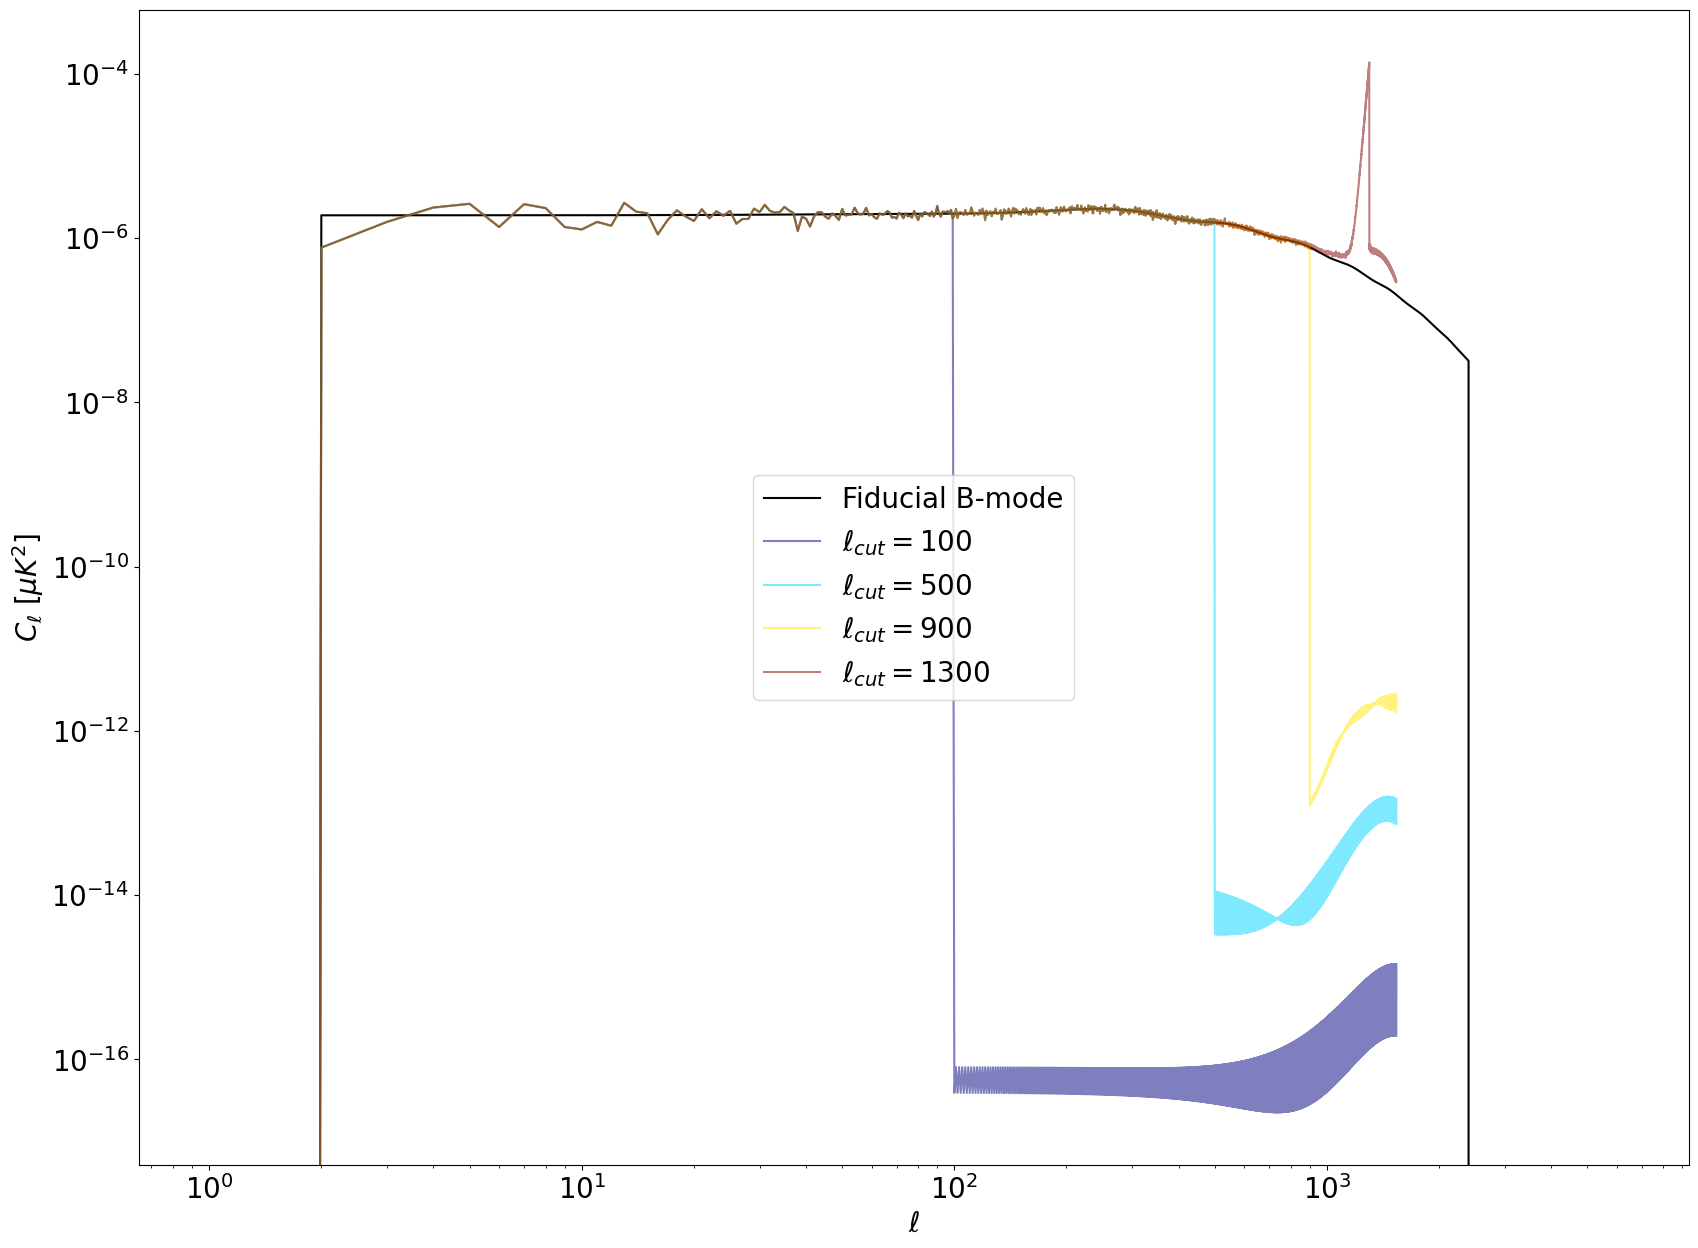

In [6]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20,15))
stokes = 2
plt.loglog(inputcl[stokes,:], label="Fiducial B-mode", color="black")
jet_colors = plt.cm.jet(np.linspace(0, 1, len(cl_list)))
for i, cl in enumerate(cl_list):
    plt.loglog(cl[stokes, :], color=jet_colors[i], label="$\ell_{cut}=$"+str(cut_off[i]), alpha=0.5)
plt.legend()
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell$ [$\mu K^2$]")

## We can see $\ell_{cut}=900,1300$ have a tail in residual map's power spectrum. It is not preferavle. $\ell_{cut}$ lee than 500, the residual power spectra look flat. So we conclude $\ell_{max}=191$ which is used in PTEP likelihood is can be used for $\ell_{cut}$.

Text(0, 0.5, '$C_\\ell$ [$\\mu K^2$]')

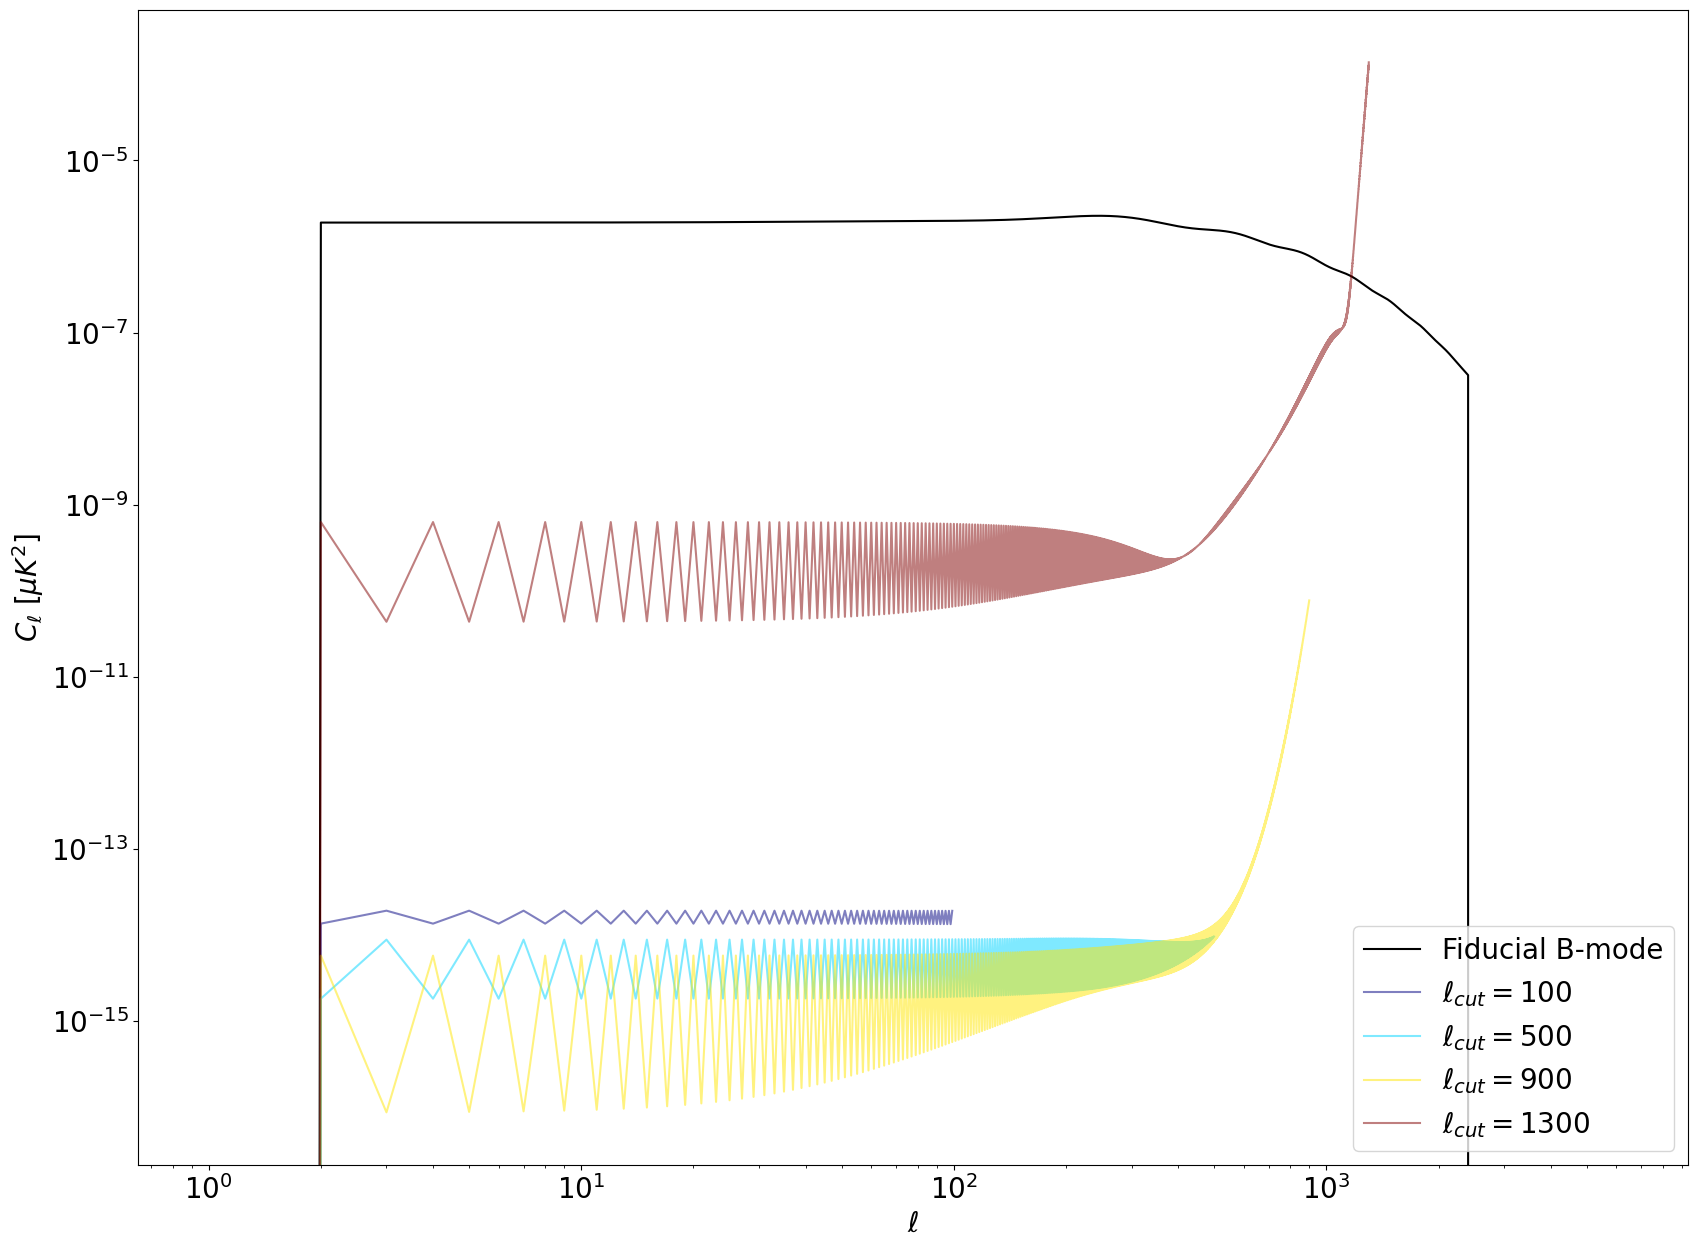

In [7]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20,15))
stokes = 2
plt.loglog(inputcl[stokes,:], label="Fiducial B-mode", color="black")
jet_colors = plt.cm.jet(np.linspace(0, 1, len(cl_list)))
for i, cl in enumerate(rescl_list):
    plt.loglog(cl[stokes, :cut_off[i]], color=jet_colors[i], label="$\ell_{cut}=$"+str(cut_off[i]), alpha=0.5)
plt.legend()
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell$ [$\mu K^2$]")